In [2]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

In [91]:
#runlist = np.arange(401, 405 , 1)
#runlist = [34,39] #vert pol
#runlist = [36,40] #hor pol
runlist = [103] #d4py vpol
#runlist = [104] #d4py hpol
runlist=[90,92,94] # dmm 150ps
runlist=[244,247,249] # dmm 75fs
runlist=[250,255] # dmm 10ps
runlist=[278] # n2q 50ps
Loaddir = '../Claudio/Reduced_XANES/'
pgroup = 'p21005'
##############################################
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 1 runs: [278] from ../Claudio/Reduced_XANES/


## check data files

In [92]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:    
    file = glob.glob(Loaddir + '/*{:04d}*/*XANES*npy*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
#datafiles    

[278]
5 files found


# Plotting averaged XANES  spectra (same X range)
### load and average data

In [93]:
diode_array = ['XANES_DataDiode1_pump', 'XANES_DataDiode1_unpump', 'XANES_Pump_probe_Diode1',
               'XANES_DataDiode2_pump', 'XANES_DataDiode2_unpump', 'XANES_Pump_probe_Diode2'
              ]

goodshots_array = ['XANES_goodshots1', 'XANES_goodshots2']

for file in glob.glob(Loaddir+'XANES*.npy'):
    os.remove(file)
    
for spec in diode_array:
    dfiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        dfiles.append(file)
    dfiles = itertools.chain.from_iterable(dfiles)
    dfiles = sorted(dfiles, key = os.path.getmtime)
    spec2save = []
    if len(dfiles)>0:
        for ff in dfiles:
            spec2save.append(np.load(ff, allow_pickle=True))
        print (len(dfiles), spec, np.shape(spec2save))
        np.save(Loaddir+spec+'_all.npy', spec2save)
    else:
        print ('File not found for: {}'.format(spec))
    #print (len(patch), spec, np.shape(spec2save))
    #np.save(Loaddir+spec+'_all.npy', spec2save)
for item in goodshots_array:
    dfiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,item))
        dfiles.append(file)
    dfiles = itertools.chain.from_iterable(dfiles)
    dfiles = sorted(dfiles, key = os.path.getmtime)
    goodshots2save = []
    if len(dfiles)>0:
        for ff in dfiles:
            goodshots2save.append(np.load(ff, allow_pickle=True))
        print (len(dfiles), item, np.shape(goodshots2save))
        np.save(Loaddir+item+'_all.npy', goodshots2save)  
    else:
        print ('File not found for: {}'.format(item))

1 XANES_DataDiode1_pump (1, 91, 3)
1 XANES_DataDiode1_unpump (1, 91, 3)
1 XANES_Pump_probe_Diode1 (1, 91, 3)
File not found for: XANES_DataDiode2_pump
File not found for: XANES_DataDiode2_unpump
File not found for: XANES_Pump_probe_Diode2
1 XANES_goodshots1 (1, 91)
File not found for: XANES_goodshots2


In [94]:
DataDiode1_pump_all = np.load(Loaddir+'/XANES_DataDiode1_pump_all.npy', allow_pickle=True)
DataDiode1_unpump_all = np.load(Loaddir+'/XANES_DataDiode1_unpump_all.npy', allow_pickle=True)
Pump_probe1_all = np.load(Loaddir+'/XANES_Pump_probe_Diode1_all.npy', allow_pickle=True)
goodshots1_all = np.load(Loaddir+'/XANES_goodshots1_all.npy',allow_pickle=True)
try:
    DataDiode2_pump_all = np.load(Loaddir+'/XANES_DataDiode2_pump_all.npy', allow_pickle=True)
    DataDiode2_unpump_all = np.load(Loaddir+'/XANES_DataDiode2_unpump_all.npy', allow_pickle=True)
    Pump_probe2_all = np.load(Loaddir+'/XANES_Pump_probe_Diode2_all.npy', allow_pickle=True)
    goodshots2_all = np.load(Loaddir+'/XANES_goodshots2_all.npy', allow_pickle=True)
except:
    print ('Diode2 files not found')

Diode2 files not found


In [95]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
try:
    XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
    err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
    err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
    err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
    err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
except:
    print ('Diode2 files not found')

Diode2 files not found


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Diode2 files not found


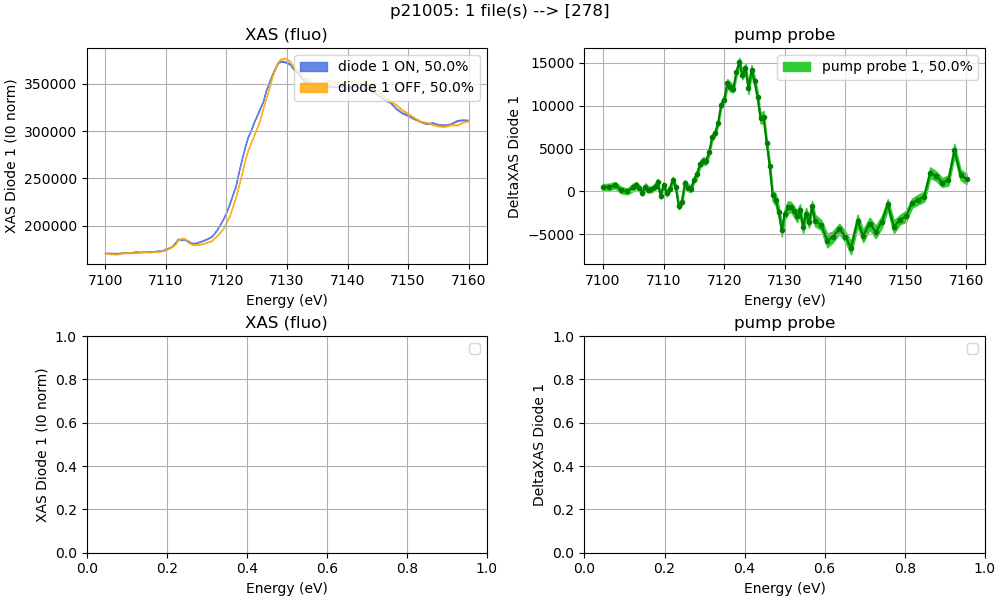

In [96]:
quantile_corr = 0.5

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup, len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{:04d}*/XANES_energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])

ax1.fill_between(Energy_eV, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Energy_eV, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Energy_eV, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Energy_eV, XAS1_pump_probe, color='green', marker='.')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
try:
    ax2.fill_between(Energy_eV, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
    ax2.fill_between(Energy_eV, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
    ax4.fill_between(Energy_eV, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
    ax4.plot(Energy_eV, XAS2_pump_probe, color='green', marker='.')
    #ax4.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
except:
    print ('Diode2 files not found')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 1 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Energy (eV)")
ax4.set_ylabel ("DeltaXAS Diode 1")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

In [28]:
#runs 90,92,94
dmm_150ps=XAS1_pump_probe
dmm_150psR=XAS1_pump_probe/XAS1_unpump

In [212]:
xas_hpol=XAS1_pump_probe#/XAS1_unpump

ValueError: x and y must have same first dimension, but have shapes (90,) and (89,)

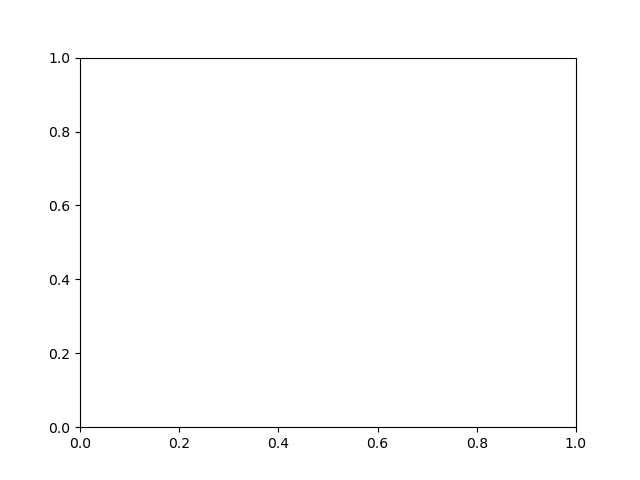

In [216]:
fig, ax1 = plt.subplots()
ax1.plot(Energy_eV,xas_hpol,label='hpol')
ax1.plot(Energy_eV,xas_vpol,label='vpol')
plt.title('delay=300fs')
plt.xlabel('Energy (eV)')
plt.ylabel('Absolute difference to unpumped')
plt.axhline(0,color='k')
plt.legend()
plt.show()

#fig, ax1 = plt.subplots()
#ax1.plot(Energy_eV,rxas_hpol,label='hpol')
#ax1.plot(Energy_eV,rxas_vpol,label='vpol')
#plt.title('E = 7123 eV')
#plt.xlabel('Energy (eV)')
#plt.ylabel('Relative difference to unpumped')
#plt.axhline(0,color='k')
#plt.legend()
#plt.show()

## Average the 2 diodes

In [ ]:
##Average first, subtract later

ave_unpump = (XAS1_unpump-np.mean(XAS1_unpump[0:5]) + XAS2_unpump-np.mean(XAS2_unpump[0:5]))/2        ### subtracts the baseline
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-np.mean(XAS1_pump[0:5]) + XAS2_pump-np.mean(XAS2_pump[0:5]))/2                  ### subtracts the baseline
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

ave_pp1 = ave_pump - ave_unpump
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup,len(runlist),str(runlist)))

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON')
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='OFF')
ax1.grid()
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.legend()

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Energy_eV, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.grid()
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
ax2.legend()
plt.show()

In [ ]:
fig, ax1= plt.subplots(1, 1, figsize=(9, 5), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup,len(runlist),str(runlist)))

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON') 
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='ON') 
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.set_xlabel('Energy (eV)')

ax2 = plt.twinx(ax1)
ax2.axes.errorbar(Energy_eV, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen', alpha=0.5)
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
plt.show()

## save the averaged spectra to load them overlaid

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_XANES/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump_all[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump_all[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe1_all[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1_all, axis=0)

save_run_array_XANES(reducedir, run_name, Energy_eV, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

# Overlay different XANES  spectra
### load data

In [110]:
#runlist = np.arange(246, 249, 1)
#runlist = [27,25,28,23,24]
runlist = [282,288,302]

Loaddir = '../Claudio/Reduced_XANES/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [282, 288, 302] from ../Claudio/Reduced_XANES/


['../Claudio/Reduced_XANES/run0282-N4PY_2p_energy_2ps_6uJ/run_array.npy',
 '../Claudio/Reduced_XANES/run0288-N4PY_2p_energy_2ps_6uJ/run_array.npy',
 '../Claudio/Reduced_XANES/run0302-N4PY_2p_energy_2ps_6uJ/run_array.npy']

# TWO DIODES

No handles with labels found to put in legend.


Diode2 files not found
Diode2 files not found
Diode2 files not found


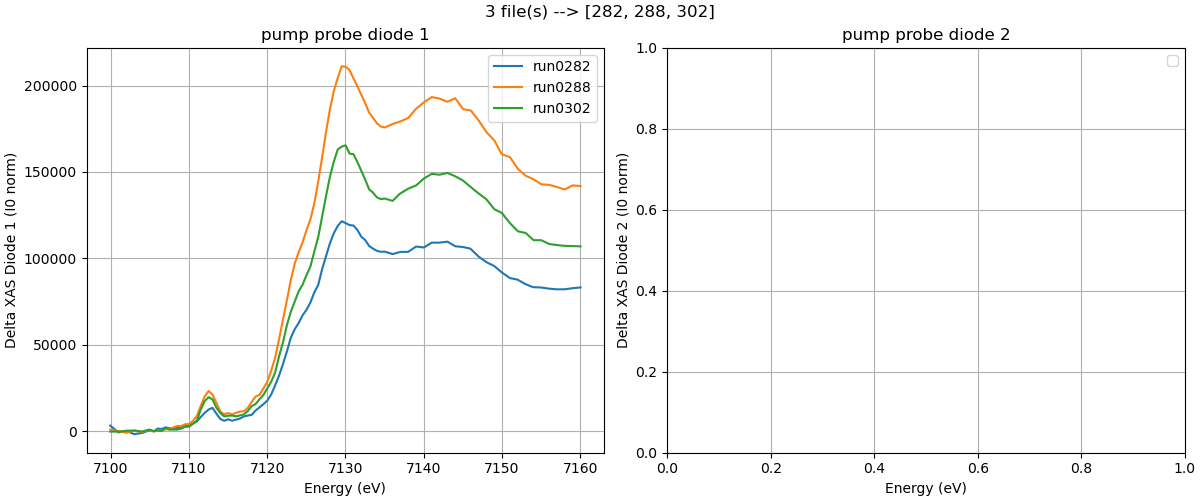

[282, 288, 302]


In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

delays = ['150fs','2ps','10ps','50ps', '75fs']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        lab = delays[index]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber+': '+lab)
        ax1.plot(Energy_eV, (D1u[:,0] - np.mean(D1u[:5,0])) , label=runnumber)
        #ax2.plot(Energy_eV, (D1u[:,0] - np.mean(D1u[:5,0]))/np.max(D1u[:,0]) , label=runnumber)
        #ax1.plot(Energy_eV, D1p[:,0])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
            
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            #ax2.plot(Energy_eV, XAS2_pump_probe[:,0])
            #ax2.axes.errorbar(Energy_eV, D2u[:,0], err2_low_unpump, err2_high_unpump, label=runnumber)
        
        except:
            print ('Diode2 files not found')
        
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.grid()
ax1.legend()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()
print(runlist)

# ONE diode

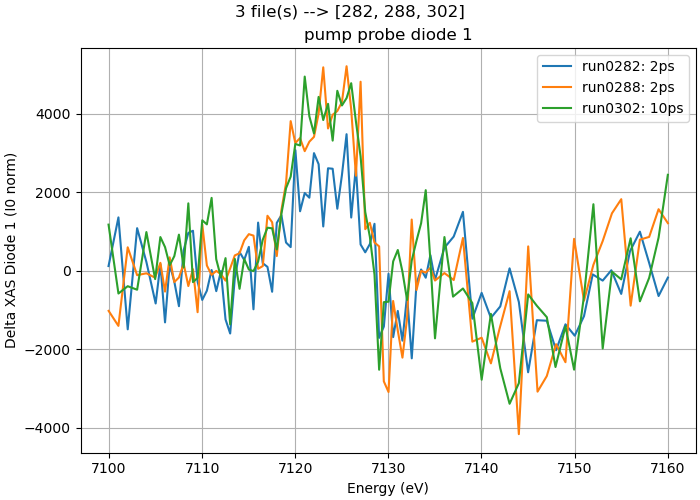

In [112]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []
#runlist = [71, 73, 74] #excluding run 65 test
delays = ['2ps','2ps','10ps','50ps', '75fs']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        lab = delays[index]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber+': '+lab)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], (err1_low_pump_probe + err1_high_pump_probe)/2, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/max(XAS1_pump_probe[:,0]), err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0]-np.mean(D1u[:5,0]), (err1_low_pump_probe+err1_high_pump_probe)/2, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')
plt.show()

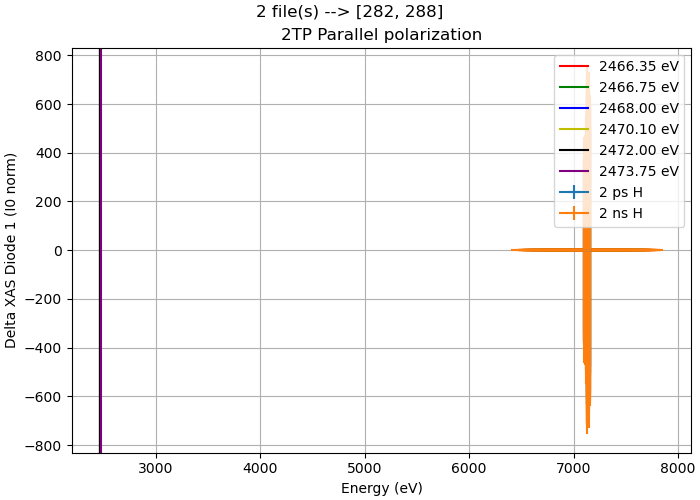

In [109]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']
labels = ['2 ps H', '2 ns H', ]

for i, (run, lbl) in enumerate(zip(runlist[::],labels[::])):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=lbl)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('2TP Parallel polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans
colors = ['r','g','b','y','k','purple']
for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee),color = colors[ii])
plt.legend()
plt.show()

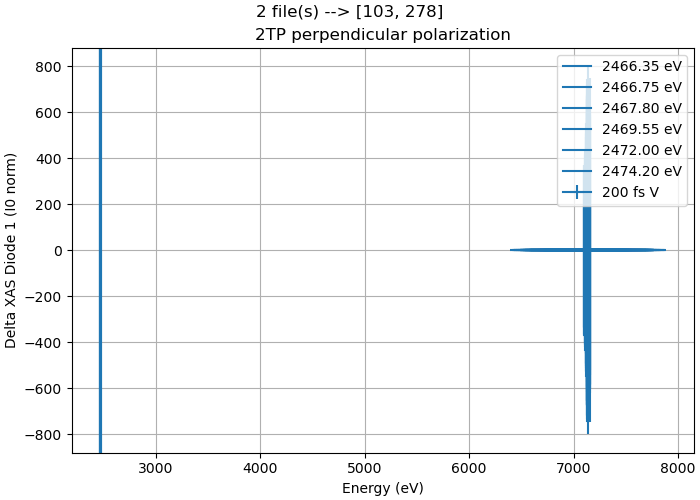

In [89]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']

for i, (run, lbl) in enumerate(zip(runlist[1::2],labels[1::2])):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=lbl)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('2TP perpendicular polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
#energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans

for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee))
plt.legend()
plt.show()

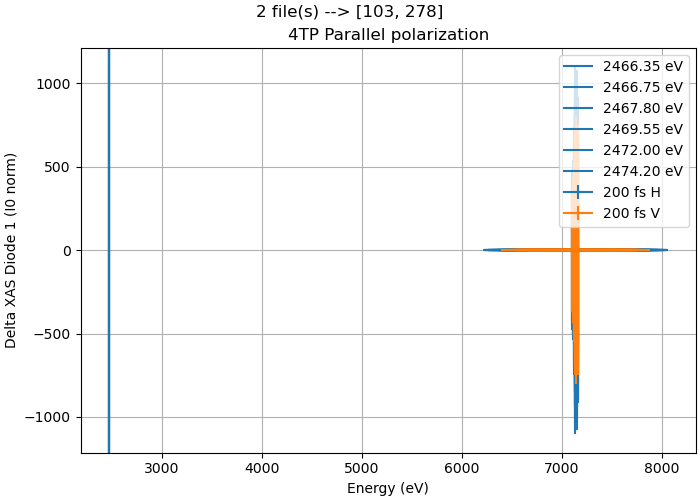

In [90]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']

for i, run in enumerate(runlist[:]):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('4TP Parallel polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
#energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans

for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee))
plt.legend()
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

#labels = ['200 fs', '500 fs', '2 ps', '20 ps', '200 ps', '2 ns']
#labels = ['20 ps', '200 ps', '2 ns', '20 ns']
labels = ['scan 18','scan 27',  'scan 167']

for i, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])-np.nanmean(D1u[0:5,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, (D1u[:,0]-D1u[0,0])/(D1u[-1,0]-D1u[0,0]), err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')

plt.show()

### convert npy to mat files

In [ ]:
Loaddir = '../Claudio/Reduced_timescans/averaged/'

import scipy.io
f = glob.glob(Loaddir + '/*/*.npy*')

for file in f:
    temp = np.load(file, allow_pickle=True)
    mdic = {"data": temp,}
    fname = file.split('/')[-1].split('.')[0]
    path = os.path.dirname(file) + '/' + fname
    print (path + '/' + fname)
    scipy.io.savemat(path +'.mat', mdic)